# Running a Surface wetting Workflow with flowerMD

## Overview:

This notebook demonstrates how to run a surface wetting workflow with flowerMD. For demonstration purposes, we will create a Poly(ethylene) droplet on a graphene surface. The workflow consists of the following steps:

1. Create a droplet of the polymer melt
2. Create a graphene surface
3. Combine the droplet and surface into a single system
4. Run wetting simulation

## Step 1: Create a droplet

Let's start by creating a Poly(ethylene) droplet. We will use the `PolyEthylene` class from the `flowermd.library.polymers` module to create a Poly(ethylene) melt. We will then use the `Pack` class from the `flowermd.base.system` module to create the system.

Next step is to start the droplet simulation by using the `DropletSimulation` class from the `flowermd.modules.surface_wetting` module. We will use the `DropletSimulation.from_system` method to create the simulation object from the system object. This method will automatically create the simulation object with the correct parameters for the droplet simulation.

In [1]:
from cmeutils.visualize import FresnelGSD
import warnings

warnings.filterwarnings("ignore")

In [ ]:
from flowermd.base.system import Pack
from flowermd.library.polymers import PolyEthylene
from flowermd.library.forcefields import OPLS_AA
from flowermd.internal import Units

In [3]:
polyethylene = PolyEthylene(num_mols=70, lengths=25)
droplet_system = Pack(molecules=polyethylene, density=1.0 * Units.g_cm3)
droplet_system.apply_forcefield(
    force_field=OPLS_AA(),
    remove_charges=True,
    remove_hydrogens=True,
    auto_scale=True,
    r_cut=2.5,
)

No charged group detected, skipping electrostatics.


In [4]:
from flowermd.modules.surface_wetting import DropletSimulation

droplet_sim = DropletSimulation.from_system(
    droplet_system,
    gsd_file_name="droplet_trajectory.gsd",
    log_file_name="droplet_sim_data.txt",
)

Initializing simulation state from a gsd.hoomd.Frame.


<div class="alert alert-block alert-warning"><b>Warning:</b> Due to the large system size, the following cell may take approximately 30 minutes to an hour to run.</div>

**Run the droplet simulation:**

The `run_droplet` method runs the droplet simulation. The method takes the following steps:
1. Shrink the box to a high density at a high temperature. This allows the polymer chains to pack tightly.
2. Expand the box to a low density at a low temperature. This allows the polymer chains to relax and form a droplet.
3. Hold the box at a low density at a low temperature. This allows the droplet to equilibrate.

In [5]:
# Uncomment the code-block below to try creating a polymer droplet.

"""
droplet_sim.run_droplet(
    tau_kt=droplet_sim.dt * 100,
    shrink_temperature=5.0,
    shrink_duration=1e6,
    shrink_period=1000,
    shrink_density=1.4,
    expand_temperature=0.5,
    expand_duration=2e6,
    expand_period=1000,
    hold_temperature=0.5,
    hold_duration=1e5,
    final_density=0.05
)
droplet_sim.flush_writers()
"""

Step 5500 of 1000000; TPS: 4430.1; ETA: 3.7 minutes
Step 11000 of 1000000; TPS: 5819.2; ETA: 2.8 minutes
Step 16500 of 1000000; TPS: 6526.52; ETA: 2.5 minutes
Step 22000 of 1000000; TPS: 6887.89; ETA: 2.4 minutes
Step 27500 of 1000000; TPS: 7064.29; ETA: 2.3 minutes
Step 33000 of 1000000; TPS: 7256.48; ETA: 2.2 minutes
Step 38500 of 1000000; TPS: 7390.48; ETA: 2.2 minutes
Step 44000 of 1000000; TPS: 7495.81; ETA: 2.1 minutes
Step 49500 of 1000000; TPS: 7536.11; ETA: 2.1 minutes
Step 55000 of 1000000; TPS: 7606.21; ETA: 2.1 minutes
Step 60500 of 1000000; TPS: 7664.35; ETA: 2.0 minutes
Step 66000 of 1000000; TPS: 7705.19; ETA: 2.0 minutes
Step 71500 of 1000000; TPS: 7754.1; ETA: 2.0 minutes
Step 77000 of 1000000; TPS: 7798.08; ETA: 2.0 minutes
Step 82500 of 1000000; TPS: 7830.02; ETA: 2.0 minutes
Step 88000 of 1000000; TPS: 7864.54; ETA: 1.9 minutes
Step 93500 of 1000000; TPS: 7892.64; ETA: 1.9 minutes
Step 99000 of 1000000; TPS: 7919.92; ETA: 1.9 minutes
Step 104500 of 1000000; TPS: 794

<div class="alert alert-block alert-info"> <b>Note:</b> In order to reach the perfect droplet shape, you might need to try different parameters (e.g. system size, density, and temperatures) and check the trajectory to see if the droplet is forming.
</div>


For demonstration purposes and to save time, we will use the pre-run droplet simulation snapshot for the above system, saved in the `data` directory.

In [6]:
import gsd.hoomd

droplet_snapshot = gsd.hoomd.open("data/polyethylene_droplet.gsd")[0]

Here is a visualization of the droplet:

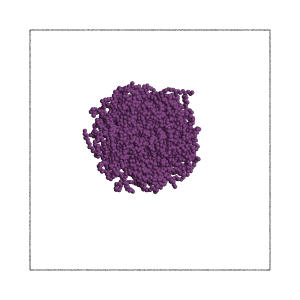

In [7]:
sim_viewer = FresnelGSD(
    gsd_file="data/polyethylene_droplet.gsd", view_axis=(0, 1, 0), frame=-1
)
sim_viewer.view()

Since we will need the forcefield and reference values of the droplet system later, we will create a new droplet system with a smaller number of molecules and save the forcefield and reference values.

In [8]:
polyethylene_small = PolyEthylene(num_mols=10, lengths=5)
droplet_system_small = Pack(molecules=polyethylene_small, density=1.0)
droplet_system_small.apply_forcefield(
    force_field=OPLS_AA(),
    remove_charges=True,
    remove_hydrogens=True,
    auto_scale=True,
    r_cut=2.5,
)

No charged group detected, skipping electrostatics.


In [9]:
droplet_ff = droplet_system_small.hoomd_forcefield
droplet_ref_values = droplet_system_small.reference_values

## Step 2: Create a graphene surface

We will use the `Graphene` class from the `flowermd.library.surfaces` to create a graphene surface. The size of the graphene surface is determined by the `x_repeat` and `y_repeat` parameters, which determine the number of unit cells in the x and y directions, respectively.  The `n_layers` parameter determines the number of graphene layers.
This class is a subclass of `System` base class, so we can use the `apply_forcefield` method to apply the force field to the graphene surface.

**Note**: We are using the droplet system's reference values to scale the graphene surface. This ensures that the graphene surface and the droplet system have the same units. Make sure to set the `auto_scale` parameter to `False` when applying the force field to the graphene surface.

In [10]:
from flowermd.library.surfaces import Graphene

graphene = Graphene(
    x_repeat=30, y_repeat=30, n_layers=2, base_units=droplet_ref_values
)
graphene.apply_forcefield(
    force_field=OPLS_AA(), remove_charges=True, auto_scale=False, r_cut=2.5
)

No charged group detected, skipping electrostatics.


## Step 3: Combine the droplet and surface systems

The `InterfaceBuilder` class from the `flowermd.modules.surface_wetting` module combines the droplet and surface snapshots by placing the droplet particles on top of the surface. The particles are placed in a box with a height equal to the `box_height` parameter. The `gap` parameter determines the distance between the droplet and the surface.

This class also combines the force fields of the droplet and surface systems, while also accounting for new LJ interactions between the droplet and surface particles.


In [11]:
from flowermd.modules.surface_wetting import InterfaceBuilder
import unyt as u

interface = InterfaceBuilder(
    surface_snapshot=graphene.hoomd_snapshot,
    surface_ff=graphene.hoomd_forcefield,
    drop_snapshot=droplet_snapshot,
    drop_ff=droplet_ff,
    drop_ref_values=droplet_ref_values,
    box_height=12 * u.nm,
    gap=0.4 * u.nm,
)

The new snapshot and force field can be accessed using the `hoomd_snapshot` and `hoomd_forcefield` attributes, respectively.

In [12]:
wetting_snapshot = interface.hoomd_snapshot
wetting_forcefield = interface.hoomd_forces

In [13]:
# save the `wetting_snapshot` to a gsd file
with gsd.hoomd.open("surface_wetting_init.gsd", "w") as traj:
    traj.append(wetting_snapshot)

Let's visualize the new snapshot containing the droplet and surface particles.

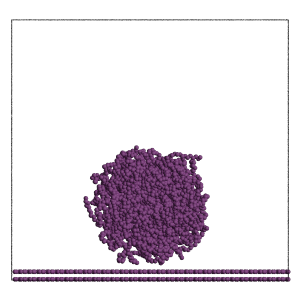

In [14]:
sim_viewer = FresnelGSD(
    gsd_file="surface_wetting_init.gsd", view_axis=(0, 1.5, 0), frame=-1
)
sim_viewer.view()

## Step 4: Run wetting simulation

The `WettingSimulation` class from the `flowermd.modules.surface_wetting` module runs the wetting simulation. The `WettingSimulation` class is a subclass of the `Simulation` base class. The `WettingSimulation` class takes the following parameters:
- `initial_state`: The snapshot containing the droplet and surface particles.
- `forcefield`: The force field containing the droplet and surface force fields.
- `fix_surface`: A boolean value that determines whether the surface particles are fixed during the simulation. If `True`, the surface particles are excluded from the integrator, meaning that they will not move during the simulation.

In [26]:
from flowermd.modules.surface_wetting import WettingSimulation

wetting_sim = WettingSimulation(
    initial_state=wetting_snapshot,
    forcefield=wetting_forcefield,
    fix_surface=True,
    gsd_file_name="wetting_trajectory.gsd",
    log_file_name="wetting_sim_data.txt",
)

Initializing simulation state from a gsd.hoomd.Frame.


Now we can start the wetting simulation by using the `run_NVT` method. The droplet slowly spreads on the surface, and eventually wets the surface.

<div class="alert alert-block alert-warning"><b>Warning:</b> Due to the large system size, the following cells may take approximately 30 minutes to an hour to run.</div>

In [27]:
# Uncomment to run surface wetting simulation

# wetting_sim.run_NVT(temperature=3.0, duration=3e5, tau_kt=wetting_sim.dt*100)
# wetting_sim.flush_writers()

Step 5500 of 300000; TPS: 2768.52; ETA: 1.8 minutes
Step 11000 of 300000; TPS: 3152.5; ETA: 1.5 minutes
Step 16500 of 300000; TPS: 3284.74; ETA: 1.4 minutes
Step 22000 of 300000; TPS: 3374.16; ETA: 1.4 minutes
Step 27500 of 300000; TPS: 3428.91; ETA: 1.3 minutes
Step 33000 of 300000; TPS: 3467.3; ETA: 1.3 minutes
Step 38500 of 300000; TPS: 3502.33; ETA: 1.2 minutes
Step 44000 of 300000; TPS: 3531.35; ETA: 1.2 minutes
Step 49500 of 300000; TPS: 3546.18; ETA: 1.2 minutes
Step 55000 of 300000; TPS: 3563.27; ETA: 1.1 minutes
Step 60500 of 300000; TPS: 3577.47; ETA: 1.1 minutes
Step 66000 of 300000; TPS: 3588.54; ETA: 1.1 minutes
Step 71500 of 300000; TPS: 3598.05; ETA: 1.1 minutes
Step 77000 of 300000; TPS: 3606.74; ETA: 1.0 minutes
Step 82500 of 300000; TPS: 3613.64; ETA: 1.0 minutes
Step 88000 of 300000; TPS: 3618.97; ETA: 1.0 minutes
Step 93500 of 300000; TPS: 3624.17; ETA: 0.9 minutes
Step 99000 of 300000; TPS: 3628.86; ETA: 0.9 minutes
Step 104500 of 300000; TPS: 3632.6; ETA: 0.9 minu

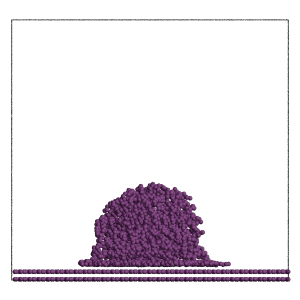

In [28]:
sim_viewer = FresnelGSD(
    gsd_file="wetting_trajectory.gsd", view_axis=(0, 1.5, 0), frame=-1
)
sim_viewer.view()

In [29]:
# Uncomment to run the surface wetting simulation longer:

# wetting_sim.run_NVT(temperature=3.0, duration=2e5, tau_kt=wetting_sim.dt*100)
# wetting_sim.flush_writers()

Step 2500 of 200000; TPS: 3603.28; ETA: 0.9 minutes
Step 8000 of 200000; TPS: 3626.52; ETA: 0.9 minutes
Step 13500 of 200000; TPS: 3627.33; ETA: 0.9 minutes
Step 19000 of 200000; TPS: 3622.36; ETA: 0.8 minutes
Step 24500 of 200000; TPS: 3625.28; ETA: 0.8 minutes
Step 30000 of 200000; TPS: 3628.58; ETA: 0.8 minutes
Step 35500 of 200000; TPS: 3630.27; ETA: 0.8 minutes
Step 41000 of 200000; TPS: 3631.99; ETA: 0.7 minutes
Step 46500 of 200000; TPS: 3632.77; ETA: 0.7 minutes
Step 52000 of 200000; TPS: 3633.59; ETA: 0.7 minutes
Step 57500 of 200000; TPS: 3631.47; ETA: 0.7 minutes
Step 63000 of 200000; TPS: 3632.64; ETA: 0.6 minutes
Step 68500 of 200000; TPS: 3633.33; ETA: 0.6 minutes
Step 74000 of 200000; TPS: 3633.98; ETA: 0.6 minutes
Step 79500 of 200000; TPS: 3634.04; ETA: 0.6 minutes
Step 85000 of 200000; TPS: 3634.52; ETA: 0.5 minutes
Step 90500 of 200000; TPS: 3634.92; ETA: 0.5 minutes
Step 96000 of 200000; TPS: 3633.84; ETA: 0.5 minutes
Step 101500 of 200000; TPS: 3633.35; ETA: 0.5 mi

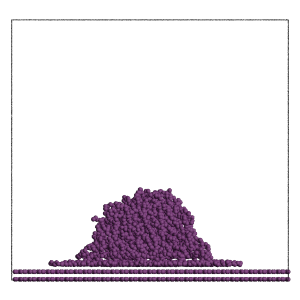

In [30]:
sim_viewer = FresnelGSD(
    gsd_file="wetting_trajectory.gsd", view_axis=(0, 1.5, 0), frame=-1
)
sim_viewer.view()